# **hkl_soleil** E6C $\psi$ (psi) axis

Show how to set, compute, and scan $\psi$ with the E6C diffractometer geometry.
Use the `hkl_soleil` solver.  Scan $\psi$ at fixed $Q$ and $hkl_2$.

Virtual axes, such as $\psi$, are features provided by the solver as *extras*.
*Extras* are not necessarily available in every solver.  Consult the solver
documentation for details.

---

**NOTE**

> **&#9432;**  The demonstrations below rely on features provided by the
> `hkl_soleil` solver.

---

## Overview

To work with $\psi$ we'll use the `"hkl"` engine of the E6C geometry. To compute
$\psi$ we'll use the `"psi"` engine.  This table summarizes our use:

engine | how it is used
--- | ---
`"hkl"` | work in reciprocal-space coordinates $h, k, l$
`"psi"` | compute the $\psi$ rotation angle (not for operations)

<!--
TODO: compare with APS POLAR geometry

See J. Appl. Cryst. (1999). 32, 943-950, https://doi.org/10.1107/S0021889899007347
"Angle calculations for a six-circle κ diffractometer"
G. Thorkildsen, R. H. Mathiesen and H. B. Larsen

Also, DLS has a K6C at I16
https://indico.psi.ch/event/12738/contributions/38939/attachments/22657/39873/NOBUGS2022_diffcalc_v2.pdf
-->

$\psi$ is the rotation of reference vector $hkl_2$ perpendicular to scattering
vector $Q$:

<img src="../_static/psi-angle.png" width="400" />

color | description
--- | ---
blue | incident and exit X-ray beams
green | scattering vector ($Q$)
red | reference vector ($hkl_2$)
yellow | rotation ($\psi$) from $hkl_2$ around $Q$
black | principle cartesian axes
gray | sample

### Steps

1. With the `"hkl"` engine:
    1. Orient a crystalline sample with the `"hkl"` engine.
    1. Define the azimuthal reflection $h_2, k_2, l_2$ and a $\psi$ rotation around
    that azimuthal reflection.
    1. Position the diffractometer for the $h, k, l$ reflection.
1. With the `"psi"` engine:
    1. Copy sample and orientation information from the `"hkl"` instance.
    1. Copy position information:
       - This step is necessary since this notebook uses *simulated* motors.
       - Diffractometers using EPICS motors will do this automatically.
    1. Compute `psi`.
    1. Compare the computed `psi` value with the value set with the `"hkl"` instance.
1. Scan $\psi$ at fixed $Q$ and $hkl_2$.

## Setup SimulatedE6C

Create instances of (simulated) E6C for the `"hkl"` and `"psi"` solver engines.
Pre-defined simulator classes are available for both engines.

In [1]:
from hklpy2 import SimulatedE6C, SimulatedE6C_Psi

e6c_hkl = SimulatedE6C(name="e6c_hkl")
e6c_psi = SimulatedE6C_Psi(name="e6c_psi")

Show the different calculation engines available for the E6C geometry.

---

**NOTE**

> **&#9432;**  The `solver` works at a lower level than ophyd.  All the code and
> structures used by a solver are pure Python code (or calls from Python to
> lower level libraries.)

---

In [2]:
print(f"{e6c_hkl.operator.solver.engines=}")

e6c_hkl.operator.solver.engines=['hkl', 'psi', 'q2', 'qper_qpar', 'tth2', 'incidence', 'emergence']


Show the different operation modes available with each engine for the E6C geometry.

The `hkl` engine has a `"psi_constant_vertical"` mode that can be used to calculate reals given some fixed parameters (UB, wavelength, $(hkl)$, $(hkl)_2$, $\psi$).  The `psi` engine has only one mode.

In [3]:
print(f"{e6c_hkl.operator.solver.modes=}")
print(f"{e6c_psi.operator.solver.modes=}")

e6c_hkl.operator.solver.modes=['bissector_vertical', 'constant_omega_vertical', 'constant_chi_vertical', 'constant_phi_vertical', 'lifting_detector_phi', 'lifting_detector_omega', 'lifting_detector_mu', 'double_diffraction_vertical', 'bissector_horizontal', 'double_diffraction_horizontal', 'psi_constant_vertical', 'psi_constant_horizontal', 'constant_mu_horizontal']
e6c_psi.operator.solver.modes=['psi_vertical']


Show the extra axes available with each mode used by this notebook.  (The extras
have default values at this time.)

The `psi` engine has a pseudo axis `"psi"` that can be used to calculate $\psi$ given some fixed parameters (reals, UB, wavelength, $(hkl)$, $(hkl)_2$)

In [4]:
e6c_hkl.operator.solver.mode = "bissector_vertical"
print(f"{e6c_hkl.operator.solver.mode=}")
print(f"{e6c_hkl.operator.solver.extras=}")

e6c_hkl.operator.solver.mode = "psi_constant_vertical"
print(f"{e6c_hkl.operator.solver.mode=}")
print(f"{e6c_hkl.operator.solver.extras=}")

# "psi" engine has only one mode, do not need to set it
print(f"{e6c_psi.operator.solver.mode=}")
print(f"{e6c_psi.operator.solver.extras=}")

e6c_hkl.operator.solver.mode='bissector_vertical'
e6c_hkl.operator.solver.extras={}
e6c_hkl.operator.solver.mode='psi_constant_vertical'
e6c_hkl.operator.solver.extras={'h2': 1.0, 'k2': 0.0, 'l2': 0.0, 'psi': 0.0}
e6c_psi.operator.solver.mode='psi_vertical'
e6c_psi.operator.solver.extras={'h2': 1.0, 'k2': 1.0, 'l2': 1.0}


### Define and orient a sample

The sample for this notebook is crystalline vibranium, with a cubic lattice of exactly $2\pi$.  With it mounted on oru diffractometer, we have identified two reflections which define its orientation.

In [5]:
import math

e6c_hkl.wavelength.put(1.54)  # angstrom (8.0509 keV)

e6c_hkl.add_sample("vibranium", 2 * math.pi, digits=5)

e6c_hkl.add_reflection((4, 0, 0), (0, 29.354, 0, 2, 0, 58.71), name="r400")
e6c_hkl.add_reflection((0, 4, 0), (0, 29.354, 0, 92, 0, 58.71), name="r040")
for r in e6c_hkl.sample.reflections.order:
    print(f"{e6c_hkl.sample.reflections[r]}")
e6c_hkl.operator.calc_UB(*e6c_hkl.sample.reflections.order)

print(f"{e6c_hkl.operator.solver.UB=!r}")
print(f"{e6c_hkl.operator.solver.U=!r}")

Reflection(name='r400', geometry='E6C', pseudos={'h': 4, 'k': 0, 'l': 0}, reals={'mu': 0, 'omega': 29.354, 'chi': 0, 'phi': 2, 'gamma': 0, 'delta': 58.71}, wavelength=1.54, digits=4)
Reflection(name='r040', geometry='E6C', pseudos={'h': 0, 'k': 4, 'l': 0}, reals={'mu': 0, 'omega': 29.354, 'chi': 0, 'phi': 92, 'gamma': 0, 'delta': 58.71}, wavelength=1.54, digits=4)
e6c_hkl.operator.solver.UB=[[0.034882054037, 0.999391435978, -0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, -0.0]]
e6c_hkl.operator.solver.U=[[0.034882054037, 0.999391435978, 0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, 0.0]]


### Move to the $(111)$ orientation

Before moving the diffractometer, ensure you have selected the desired operating
*mode*.

In [6]:
e6c_hkl.operator.solver.mode = "bissector_vertical"
e6c_hkl.move(1, 0, 0)
e6c_hkl.position, e6c_hkl.real_position

(SimulatedE6CPseudoPos(h=1.00000000737, k=-8.2488e-08, l=0),
 SimulatedE6CRealPos(mu=0, omega=7.039253278732, chi=0, phi=1.998995273774, gamma=0, delta=14.078506557465))

## Set ${hkl}_2$ and $\psi$

Show the extra axes available with `psi_constant_vertical` mode.

In [7]:
e6c_hkl.operator.solver.mode = "psi_constant_vertical"
print(f"{e6c_hkl.operator.solver.extra_axis_names=}")

e6c_hkl.operator.solver.extra_axis_names=['h2', 'k2', 'l2', 'psi']


Set azimuthal reflection ${hkl}_2 = (110)$ and $\psi=12$.

The `extras` are described as a Python dictionary with values for each of the parameters.

In [8]:
e6c_hkl.operator.solver.extras = dict(h2=1, k2=1, l2=0, psi=12)
print(f"{e6c_hkl.operator.solver.extras=}")

e6c_hkl.operator.solver.extras={'h2': 1.0, 'k2': 1.0, 'l2': 0.0, 'psi': 12.0}


Compute the real-axis motor values with the $Q=(111)$ reflection oriented and $\psi$ rotation around the azimuthal reflection.

In [9]:
p_111 = e6c_hkl.forward(1, 1, 1)
print(f"{p_111=}")

p_111=SimulatedE6CRealPos(mu=0, omega=66.391607045543, chi=99.77381778179, phi=-49.997332854697, gamma=0, delta=24.509844391025)


Move each real (real-space positioner) to the computed $(111)$ reflection position `p_111`.

In [10]:
e6c_hkl.move_reals(p_111)
print(f"{e6c_hkl.position=}")
print(f"{e6c_hkl.real_position=}")
print(f"{e6c_hkl.operator.solver.extras=}")

e6c_hkl.position=SimulatedE6CPseudoPos(h=1.000000009255, k=0.999999994159, l=0.999999984039)
e6c_hkl.real_position=SimulatedE6CRealPos(mu=0, omega=66.391607045543, chi=99.77381778179, phi=-49.997332854697, gamma=0, delta=24.509844391025)
e6c_hkl.operator.solver.extras={'h2': 1.0, 'k2': 1.0, 'l2': 0.0, 'psi': 12.0}


## Compute $\psi$ at fixed $Q$ and $hkl_2$

We'll use the `"psi"` engine to compute $\psi$, given a sample & orientation,
${hkl}_2$, and the real-space motor positions.

In [11]:
print(f"{e6c_psi.operator.solver.mode=}")
print(f"{e6c_psi.operator.solver.extras=}")

e6c_psi.operator.solver.mode='psi_vertical'
e6c_psi.operator.solver.extras={'h2': 1.0, 'k2': 1.0, 'l2': 1.0}


Same sample and lattice

In [12]:
e6c_psi.add_sample("vibranium", 2 * math.pi, digits=5)

Sample(name='vibranium', lattice=Lattice(a=6.28319, system='cubic'))

Copy orientation from `hkl` instance.  Note the `psi` and `hkl` UB matrices are
not exactly equal.  Equal to about 5 decimal places.)

In [13]:
e6c_psi.operator.solver.UB = e6c_hkl.operator.solver.UB

print(f"{e6c_psi.operator.solver.UB=!r}")
print(f"{e6c_psi.operator.solver.U=!r}")

print(f"{e6c_hkl.operator.solver.UB=!r}")
print(f"{e6c_hkl.operator.solver.U=!r}")

e6c_psi.operator.solver.UB=[[0.034882112737, 0.999391462637, -7.7669e-08], [-1.1035e-07, 3.7043e-08, 0.999999954315], [0.999391567978, -0.034881973051, -8.4609e-08]]
e6c_psi.operator.solver.U=[[0.034882108064, 0.999391434092, -3.3171e-08], [-1.1035e-07, 3.7043e-08, 1.0], [0.999391434092, -0.034882108064, 1.11575e-07]]
e6c_hkl.operator.solver.UB=[[0.034882054037, 0.999391435978, -0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, -0.0]]
e6c_hkl.operator.solver.U=[[0.034882054037, 0.999391435978, 0.0], [0.0, 0.0, 1.0], [0.999391435978, -0.034882054037, 0.0]]


Set ${hkl}_2=(1, 1, 0)$.  As above, describe these parameters in a Python dictionary.

In [14]:
e6c_psi.operator.solver.extras = dict(h2=1, k2=1, l2=0)
print(f"{e6c_psi.operator.solver.extras=}")

e6c_psi.operator.solver.extras={'h2': 1.0, 'k2': 1.0, 'l2': 0.0}


Set real-space axis positions from `p_111` (above).

In [15]:
e6c_psi.move_reals(p_111)
print(f"{e6c_psi.pseudo_axis_names=}")
print(f"{e6c_psi.operator.solver.pseudo_axis_names=}")
print(f"{e6c_psi.position=}")
print(f"{e6c_psi.real_position=}")

e6c_psi.pseudo_axis_names=['psi']
e6c_psi.operator.solver.pseudo_axis_names=['psi']
e6c_psi.position=SimulatedE6C_PsiPseudoPos(psi=11.999993753339)
e6c_psi.real_position=SimulatedE6C_PsiRealPos(mu=0, omega=66.391607045543, chi=99.77381778179, phi=-49.997332854697, gamma=0, delta=24.509844391025)


Compare `hkl` and `psi` reports.

In [16]:
print(e6c_hkl)
e6c_hkl.wh()
print(e6c_psi)
e6c_psi.wh()

SimulatedE6C(prefix='', name='e6c_hkl', settle_time=0.0, timeout=None, egu='', limits=(0, 0), source='computed', read_attrs=['h', 'h.readback', 'h.setpoint', 'k', 'k.readback', 'k.setpoint', 'l', 'l.readback', 'l.setpoint', 'mu', 'omega', 'chi', 'phi', 'gamma', 'delta'], configuration_attrs=['h', 'k', 'l', 'geometry', 'solver', 'wavelength'], concurrent=True)
h=1.0 k=1.0 l=1.0
wavelength=1.54
mu=0 omega=66.3916 chi=99.7738 phi=-49.9973 gamma=0 delta=24.5098
h2=1.0 k2=1.0 l2=0 psi=12.0
SimulatedE6C_Psi(prefix='', name='e6c_psi', settle_time=0.0, timeout=None, egu='', limits=(0, 0), source='computed', read_attrs=['psi', 'psi.readback', 'psi.setpoint', 'mu', 'omega', 'chi', 'phi', 'gamma', 'delta'], configuration_attrs=['psi', 'geometry', 'solver', 'wavelength'], concurrent=True)
psi=12.0
wavelength=1.0
mu=0 omega=66.3916 chi=99.7738 phi=-49.9973 gamma=0 delta=24.5098
h2=1.0 k2=1.0 l2=0


## Scan $\psi$ at fixed $Q$ and $hkl_2$

Setup the bluesky tools needed to run scans and review data.

In [17]:
import databroker

from bluesky import RunEngine
from bluesky.callbacks.best_effort import BestEffortCallback
from ophyd.sim import noisy_det

from hklpy2 import ConfigurationRunWrapper

# Save orientation of the diffractometer.
crw = ConfigurationRunWrapper(e6c_hkl)

bec = BestEffortCallback()
bec.disable_plots()
cat = databroker.temp().v2
RE = RunEngine()
RE.subscribe(cat.v1.insert)
RE.subscribe(bec)
RE.preprocessors.append(crw.wrapper)

Scan $\psi$ over a wide range in coarse steps.

---

**NOTE**

> **&#9432;**  Since $\psi$ is an *extra* axis, it is only available with
> certain operation modes, such as `"psi_constant_vertical"`.  Be sure to set
> that before scanning.  The plan will raise a `KeyError` if the axis name is
> not recognized.  Any extra axes are not ophyd objects since they are defined
> only when certain modes are selected.  A custom plan is provided which scans
> an extra axis, while holding any pseudos or reals, and other extras at
> constant values.

---

This example chooses $Q=(210)$ and $hkl_2=(1 \bar2 0)$. (The reference $hkl_2$
was chosen to be perpendicular to $Q$.)  Save the `uid` from the scan for later
reference.

The `e6c_hkl` diffractometer is added as a detector here so that all the
positioner values will be available for plotting later.

In [18]:
e6c_hkl.operator.solver.mode = "psi_constant_vertical"
uid, = RE(
    e6c_hkl.scan_extra(
        [noisy_det, e6c_hkl],
        axis="psi",
        start=-170,
        finish=178,
        num=15,
        pseudos=dict(h=2, k=1, l=0),
        extras=dict(h2=1, k2=-2, l2=0),
    ),
)



Transient Scan ID: 1     Time: 2025-02-12 18:52:44
Persistent Unique Scan ID: 'fef2e32c-0463-4e34-b5ee-9292c723a6ce'
New stream: 'primary'
+-----------+------------+------------+------------+------------+------------+---------------+-------------+-------------+---------------+---------------+--------------------+------------+
|   seq_num |       time |  e6c_hkl_h |  e6c_hkl_k |  e6c_hkl_l | e6c_hkl_mu | e6c_hkl_omega | e6c_hkl_chi | e6c_hkl_phi | e6c_hkl_gamma | e6c_hkl_delta | e6c_hkl_extras_psi |  noisy_det |
+-----------+------------+------------+------------+------------+------------+---------------+-------------+-------------+---------------+---------------+--------------------+------------+
|         1 | 18:52:44.4 |      2.000 |      1.000 |     -0.000 |          0 |       105.904 |      10.000 |     -61.436 |             0 |        31.808 |           -170.000 |      1.004 |
|         2 | 18:52:44.5 |      2.000 |      1.000 |      0.000 |          0 |       105.904 |      34.

### Plot any motions

The only real-space axis to be moved by this scan is $\chi$.  Plot $\chi$ *vs.*
$\psi$.

axis | data name
--- | ---
$\chi$ | `e6c_hkl_chi`
$\psi$ | `e6c_hkl_extras_psi`
---

**NOTE**

> **&#9432;**  *Extra* axes are named with the `_extras` label inserted in the
> name.

---


/home/prjemian/.conda/envs/bluesky_2025_1/lib/python3.11/site-packages/databroker/intake_xarray_core/base.py:23: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


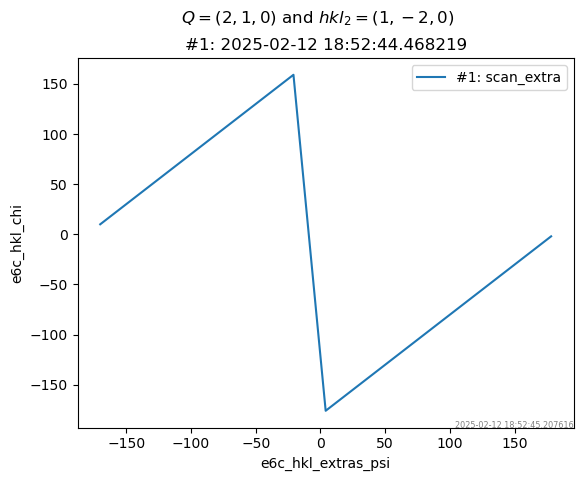

In [19]:
from apstools.utils import plotxy

run = cat[uid]

# Compose a title from current conditions.
pos = e6c_hkl.full_position(digits=0)
Q = f"({pos['h']:.0f}, {pos['k']:.0f}, {pos['l']:.0f})"
hkl2 = f"({pos['h2']:.0f}, {pos['k2']:.0f} ,{pos['l2']:.0f})"
title = f"$Q={Q}$ and $hkl_2={hkl2}$"

plotxy(run, "e6c_hkl_extras_psi", "e6c_hkl_chi", stats=False, title=title)